In [1]:
!pip install bitcoin-explorer gravis networkx tqdm

In [2]:
from collections import defaultdict
from datetime import datetime
from typing import Any, NamedTuple

import bitcoin_explorer
import gravis as gv
import networkx as nx
from tqdm.notebook import tqdm

In [3]:
data_dir: str = "D:/bitcoin_core_data/"

db = bitcoin_explorer.BitcoinDB(data_dir)

[22:54:14] INFO - Start loading block_index
[22:54:16] INFO - Successfully opened tx_index DB!


In [4]:
class TransactionInput(NamedTuple):
    value: int
    address: str

class TransactionOutput(NamedTuple):
    value: int
    address: str

class Transaction(NamedTuple):
    txid: str
    fee: int
    input: tuple[TransactionInput]
    output: tuple[TransactionOutput]

    def print(self, genesis: bool = False) -> None:
        print(f"TxID: {self.txid}")
        
        if not genesis:
            print(f"Tx Fee: {self.fee/1e8:_} BTC")

        if not genesis:
            print(f"Input:")
            for _input in self.input:
                print(f"\tValue: {_input.value/1e8:_} BTC")
                print(f"\tAddress: {_input.address}")

        print("Output:")
        for output in self.output:
            print(f"\tValue: {output.value/1e8:_} BTC")
            print(f"\tAddress: {output.address}")
        print()

class Block(NamedTuple):
    block_hash: str
    time: datetime
    genesis_transactions: tuple[Transaction]
    transactions: tuple[Transaction]

    @classmethod
    def from_db(cls, block: dict[str, Any]) -> "Block":
        header = block["header"]
        transactions = block["txdata"]
        
        block_hash: str = header["block_hash"]
        time: datetime = datetime.fromtimestamp(header["time"])
        block_transactions: list[Transaction] = []
        genesis_transactions: list[Transaction] = []

        for tx in transactions:
            tx_inputs = []
            tx_outputs = []
            
            for input in tx["input"]:
                input_address = input["addresses"]
                
                if len(input_address) == 0:
                    continue
                else:
                    input_address = input_address[0]

                
                tx_inputs.append(TransactionInput(input["value"], input_address))

            for output in tx["output"]:
                output_address = output["addresses"]
                
                if len(output_address) == 0:
                    continue
                else:
                    output_address = output_address[0]
                    
                tx_outputs.append(TransactionOutput(output["value"], output_address))

            fee = sum([input.value for input in tx_inputs]) - sum([output.value for output in tx_outputs])
            if fee < 0:
                genesis_transactions.append(Transaction(tx["txid"], fee, tx_inputs, tx_outputs))
            else:
                block_transactions.append(Transaction(tx["txid"], fee, tx_inputs, tx_outputs))

        return cls(block_hash, time, genesis_transactions, block_transactions)

    def print(self, summary: bool = False) -> None:
        print(f"{' HEADERS ':#^100}")
        print(f"{'Block Hash':}: {self.block_hash}")
        print(f"{'Time':>10}: {self.time.isoformat()}")
        print()
        if summary:
            print(f"{'Tx count':>10}: {len(self.transactions)}")
            return

        print(f"{' GENESIS ':#^100}")
        for tx in self.genesis_transactions:
            tx.print(genesis=True)
        
        print(f"{' TX-DATA ':#^100}")
        for tx in self.transactions:
            tx.print()
            

In [5]:
NUM_TOTAL_BLOCKS = db.get_max_height()
start_idx = 1_000
stop_idx = 833_094
N = 30
blocks: list[Block] = []

for n in range(1, N + 1):
    latest_block_db = db.get_block(NUM_TOTAL_BLOCKS - n, connected=True)
    latest_block = Block.from_db(latest_block_db)
    blocks.insert(0, latest_block)
        
print(f"got latest {N} blocks")

got latest 30 blocks


In [6]:
genesis_block = Block.from_db(db.get_block(0))
print(f"{genesis_block.time = }")
genesis_block

genesis_block.time = datetime.datetime(2009, 1, 3, 18, 15, 5)


Block(block_hash='000000000019d6689c085ae165831e934ff763ae46a2a6c172b3f1b60a8ce26f', time=datetime.datetime(2009, 1, 3, 18, 15, 5), genesis_transactions=[Transaction(txid='4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b', fee=-5000000000, input=[], output=[TransactionOutput(value=5000000000, address='1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa')])], transactions=[])

In [7]:
blocks[0].print(summary=True)

############################################# HEADERS ##############################################
Block Hash: 000000000000000000034fcfebad61864a503a7c8d08b14cfa09048832a663d2
      Time: 2024-03-04T06:04:59

  Tx count: 3130


In [8]:
block_inputs: set[str] = {
    input.address
    for tx in blocks[0].transactions
    for input in tx.input
}

In [9]:
def get_outputs_from_address(block: Block, target_address: str) -> dict[str, float]:
    """
    Get all addresses which received Bitcoin from a transaction 
        which this address contributed towards WITHIN THIS BLOCK.
    Returns a dictionary mapping the receiving address onto a value.
    """
    
    # use defaultdict for when multiple outputs to the same address exist (dict will overwrite keys and get total wrong)
    related_outputs: dict[str, int] = defaultdict(float)
    
    for transaction in block.transactions:
        tx_inputs = transaction.input
        tx_outputs = transaction.output

        tx_input_addresses = [input.address for input in tx_inputs]
        tx_output_addresses = [output.address for output in tx_outputs]

        target_input_value = 0.
        total_input_value = 0.
        for tx_input in tx_inputs:
            total_input_value += tx_input.value
            if tx_input.address == target_address:
                target_input_value += tx_input.value
                
        target_input_proportion = target_input_value / total_input_value
        if target_input_proportion > 1.:
            raise ValueError
        
        if target_address in tx_input_addresses:
            for output in tx_outputs:
                related_outputs[output.address] += output.value * target_input_proportion

    return dict(related_outputs)

all_outputs = {
    target: get_outputs_from_address(blocks[0], target)
    for target in block_inputs
}

addresses_by_num_outputs = sorted(
    all_outputs.keys(), 
    key=lambda k: len(all_outputs[k]), 
    reverse=True,
)

In [50]:
def get_all_receivers(
    target: str,
    blocks: list[Block],
    n: int = 3,
) -> tuple[nx.Graph, list[set[str]]]:
    """
    Get all the addresses which received bitcoins from the target
        within N blocks (directly if within the first block given, indirectly otherwise).
    """
    shells: list[set[str]] = [{target}]  # for drawing the graph, a list of which nodes should be at which level from the origin
    mappings: dict[str, set[str]] = defaultdict(set)  # mapping from node onto nodes in the next layer which received bitcoins
    balances: dict[str, float] = defaultdict(float)  # mapping from receiving address onto amount received
    
    for block_idx in range(n - 1):
        prev_shell: set[str] = shells[-1]
        shell: set[str] = set()
        for input in prev_shell:
            outputs: dict[str, float] = get_outputs_from_address(blocks[block_idx], input)
            scaler: float = 1. if input == target else balances[input]  # bootstrap first lookup
            for output, amount in outputs.items():
                mappings[input].add(output)
                shell.add(output)
                input_contribution = scaler * amount
                balances[output] += input_contribution
                
        shells.append(shell)

    graph = nx.DiGraph()
    # add the first node to the graph with its "receiving" amount as the sum of the initial receivers' balances
    graph.add_node(
        target, 
        value=sum(balances[initial_receiver] for initial_receiver in mappings[target])
    )
    for node_name, value in balances.items():
        graph.add_node(node_name, value=value)

    for u, vs in mappings.items():
        for v in vs:
            if u == v:
                continue  # don't consider "change" return as a transaction to prevent loops
            if u not in graph.nodes or v not in graph.nodes:
                raise ValueError
            graph.add_edge(u, v)

    return graph, shells

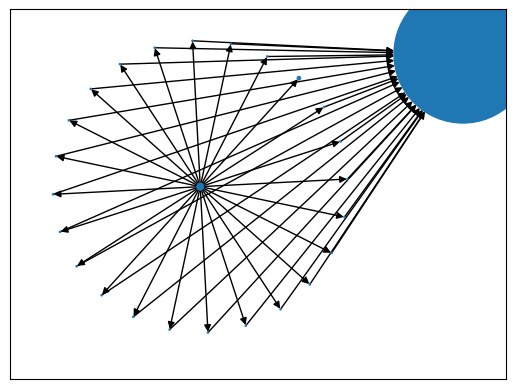

In [51]:
target = addresses_by_num_outputs[4]
graph, shells = get_all_receivers(target, blocks, n=20)
layout = nx.shell_layout(graph, shells)
nx.draw_networkx(
    graph, 
    pos=layout, 
    with_labels=False, 
    node_size=[data['value']/1e4 for _, data in graph.nodes(data=True)],
)

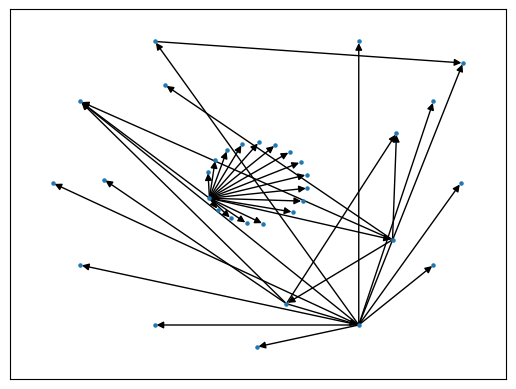

In [38]:
target = addresses_by_num_outputs[11]
graph, shells = get_all_receivers(target, blocks, n=30)
layout = nx.shell_layout(graph, shells)
nx.draw_networkx(
    graph, 
    pos=layout, 
    with_labels=False, 
    node_size=5,
)

In [39]:
print(f"{target = }")
print(f"output count = {len(all_outputs[target])}")

target = 'bc1qgclhue4f8etrn625ew64zf48lqtxwnzfcc7zm3'
output count = 19


In [40]:
target_address_outputs = get_outputs_from_address(blocks[0], target)
max(target_address_outputs.items(), key=lambda kv: kv[1])

('bc1qgclhue4f8etrn625ew64zf48lqtxwnzfcc7zm3', 8020931.708525704)

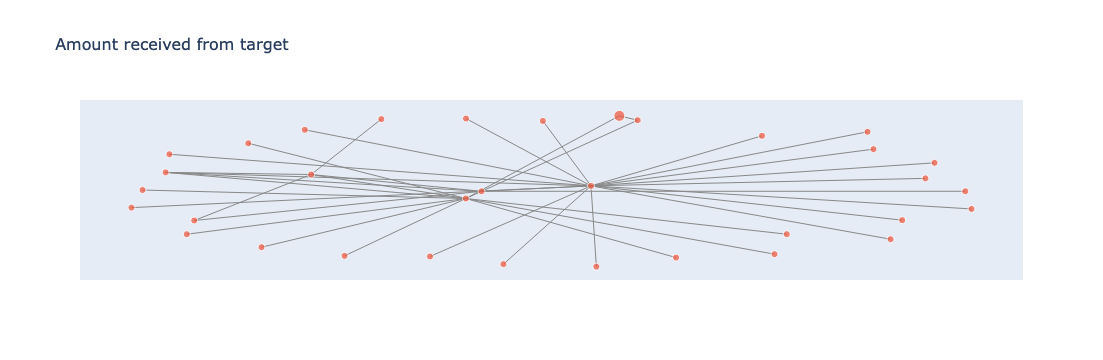

In [41]:
import plotly.graph_objects as go
from plotly import express as px
import numpy as np

pos = nx.spring_layout(graph)

edge_x = []
edge_y = []
for (u, v) in graph.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x.extend((x0, x1, None))
    edge_y.extend((y0, y1, None))

edge_trace = go.Scatter(
    x=edge_x, 
    y=edge_y,
    line=dict(
        width=1,
        color='#888',
    ),
    hoverinfo='none',
    mode='lines',
)

node_x = []
node_y = []
sizes = []
for node, data in graph.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    sizes.append(data['value'])

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        size=[10 * np.log(2 + (size / max(sizes))) for size in sizes],
    ),
)

node_text = []
for node, data in graph.nodes(data=True):
    node_text.append(f"{data['value']/1e8:.3E} BTC ({int(data['value'])} Satoshi) [ at {'TARGET' if node == target else node} ]")
    
node_trace.text = node_text

fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Amount received from target',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)
fig.show()

In [42]:
gv.d3(graph)

# Visualization of above command if interactivity is disabled

The largest (receiving) node is selected
![Screenshot of above if interactivity is disabled](./img.png)